In [1]:
import pandas as pd
import numpy as np
import operator
import time
import warnings
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.facecolor'] = 'deepskyblue'
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, auc, roc_auc_score,
    roc_curve, recall_score, precision_score, classification_report,
    f1_score, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
)

from imblearn.over_sampling import SMOTE
import itertools
import shap 
# Hide warnings
warnings.filterwarnings('ignore')




Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df_acl = pd.read_csv('MERGED_DF.csv') 

In [3]:
df_acl.shape

(17105, 25)

In [4]:
df_acl

,club_value,injury_type,age,Height,Weight,Aggression,Anticipation,Bravery,Concentration,Acceleration,...,Stamina,Strength,InjuryProness,role_Defender,role_Forward,role_Goalkeeper,role_Midfielder,foot_both,foot_left,foot_right
0,114000.0,0,24,186,83,11,14,16,14,13,...,13,13,10,0,0,1,0,0,1,0
1,114000.0,0,36,171,70,10,5,11,8,14,...,8,8,10,0,0,1,0,0,0,1
2,114000.0,0,36,184,80,12,13,13,15,12,...,13,14,4,0,0,1,0,0,0,1
3,114000.0,0,34,171,70,10,5,11,8,14,...,8,8,10,0,0,1,0,0,0,1
4,114000.0,0,34,184,80,12,13,13,15,12,...,13,14,4,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17100,4680.0,0,25,167,0,10,12,8,10,14,...,14,7,11,0,1,0,0,0,1,0
17101,4680.0,0,25,182,68,10,6,8,8,14,...,8,7,3,0,1,0,0,0,1,0
17102,4680.0,0,25,167,0,10,12,8,10,14,...,14,7,11,0,1,0,0,0,1,0
17103,4680.0,0,25,182,68,10,6,8,8,14,...,8,7,3,0,1,0,0,0,1,0


# Undersampling

Scaling before Undersampling:
Pros:
Consistency: All data is scaled uniformly. Even the data that you discard during undersampling is subjected to the same scaling transformation.
Retains Transformation Information: ensures that you retain the mean and standard deviation of the complete dataset.

In [152]:
# df_acl
X = df_acl.drop('injury_type', axis=1)  # features
y = df_acl['injury_type']               # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)


In [153]:
def undersample_data(X, y):
    # Get indices of rows with injury_type == 1 and injury_type == 0
    type_1_indices = y[y == 1].index
    type_0_indices = y[y == 0].index

    # Randomly sample from injury_type == 0 to match the number of injury_type == 1
    random_type_0_indices = np.random.choice(type_0_indices, len(type_1_indices), replace=False)
    
    # Combine the two to get the undersampled data
    undersampled_indices = np.concatenate([type_1_indices, random_type_0_indices])
    
    return X.loc[undersampled_indices], y.loc[undersampled_indices]

X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train)


In [154]:
print("Number of total samples after undersampling:", len(X_train_undersampled))
print("Number of injury type 1 after undersampling:", len(y_train_undersampled[y_train_undersampled == 1]))
print("Number of injury type 0 after undersampling:", len(y_train_undersampled[y_train_undersampled == 0]))
print("Number of total samples in the original training set:", len(X_train))
print("Number of samples in the test set:", len(y_test))


Number of total samples after undersampling: 326
Number of injury type 1 after undersampling: 163
Number of injury type 0 after undersampling: 163
Number of total samples in the original training set: 8552
Number of samples in the test set: 8553


##  tSNE
Visualise the undersampled data to see if it is separable
t-SNE is a technique for dimensionality reduction that is well-suited for the visualisation of high-dimensional datasets.Takes a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space (2D in this case)

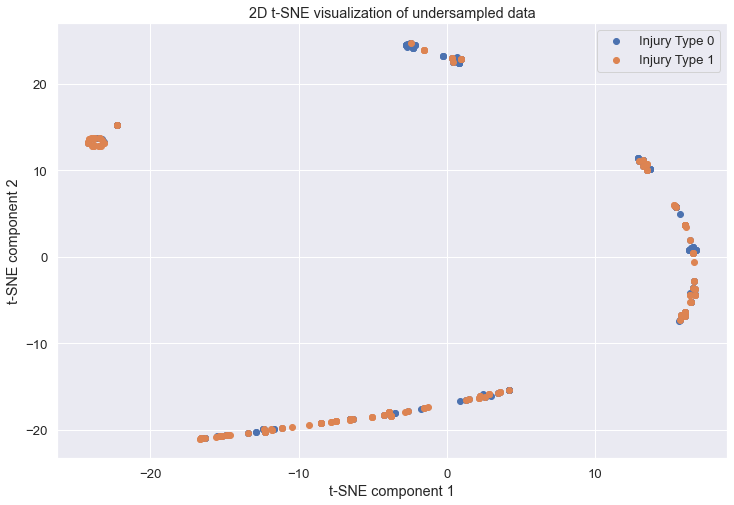

In [155]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=27)
X_tsne = tsne.fit_transform(X_train_undersampled)

# Plot the results
plt.figure(figsize=(12, 8))
for injury_type in [0, 1]:
    indices = y_train_undersampled == injury_type
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Injury Type {injury_type}')

plt.legend()
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('2D t-SNE visualization of undersampled data')
plt.show()



The x and y coordinates themselves don't carry a particular meaning, but their relative positions do.
Points that are close to each other in the t-SNE plot are similar in terms of their features in the high-dimensional data.
Points that are far from each other in the t-SNE plot are dissimilar.

# Lazy Predict 

In [156]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


# Create LazyClassifier instance
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit LazyClassifier on the data
models, predictions = clf.fit(X_train_undersampled, X_test, y_train_undersampled, y_test)

# Print the performance of all the classifiers
print(models)


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]

[LightGBM] [Info] Number of positive: 163, number of negative: 163
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 326, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.53it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
DecisionTreeClassifier             0.62               0.66     0.66      0.75   
XGBClassifier                      0.57               0.64     0.64      0.71   
LGBMClassifier                     0.59               0.63     0.63      0.73   
SVC                                0.57               0.62     0.62      0.71   
BaggingClassifier                  0.66               0.62     0.62      0.78   
ExtraTreesClassifier               0.59               0.62     0.62      0.72   
RandomForestClassifier             0.59               0.61     0.61      0.73   
RidgeClassifierCV                  0.57               0.60     0.60      0.71   
LogisticRegression                 0.57               0.60     0.60      0.71   
RidgeClassifier                    0.57               0.59     0.59      0.71   
KNeighborsClassifier        

# Random forest

## Undersampled data and RF classifier

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix, recall_score, precision_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split


In [164]:
clf = RandomForestClassifier(oob_score=True, random_state=42)
clf.fit(X_train_undersampled, y_train_undersampled)


RandomForestClassifier(oob_score=True, random_state=42)

In [165]:
y_pred = clf.predict(X_test)


In [166]:
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Out-of-Bag (OOB) Score:", clf.oob_score_)


Mean Squared Error (MSE): 0.4067578627382205
Accuracy: 0.5932421372617795
Recall: 0.6341463414634146
Precision: 0.02952029520295203
ROC AUC: 0.6132944128344608
Out-of-Bag (OOB) Score: 0.6073619631901841


<Figure size 576x432 with 0 Axes>

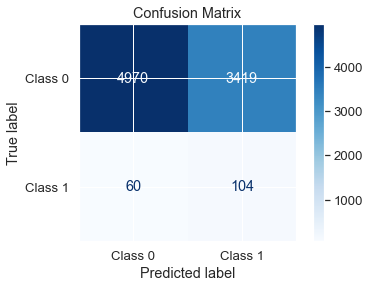

In [167]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, display_labels=["Class 0", "Class 1"], cmap=plt.cm.Blues, normalize=None)
plt.title("Confusion Matrix")
plt.show()


### Hyper parameter tuning

In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the RandomForest Classifier
clf = RandomForestClassifier()

# Define the parameters for grid search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model to the undersampled training data
grid_search.fit(X_train_undersampled, y_train_undersampled)

# Get the best parameters from the Grid Search
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters from Grid Search:", best_params)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
test_score = best_clf.score(X_test, y_test)
print(f"Test set accuracy of best model: {test_score:.4f}")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters from Grid Search: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Test set accuracy of best model: 0.6275


In [171]:
# Initialize GridSearchCV with scoring set to recall
grid_search_recall = GridSearchCV(estimator=clf, param_grid=param_grid, 
                                  cv=5, n_jobs=-1, verbose=2, scoring='recall')

grid_search_recall.fit(X_train_undersampled, y_train_undersampled)

# Get the best parameters from the Grid Search
best_params_recall = grid_search_recall.best_params_

# Print the best parameters
print("Best Parameters based on Recall:", best_params_recall)

# Evaluate the best model based on recall on the test set
best_clf_recall = grid_search_recall.best_estimator_
test_score_recall = best_clf_recall.score(X_test, y_test)
print(f"Test set accuracy of best model (recall-based): {test_score_recall:.4f}")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters based on Recall: {'bootstrap': False, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}
Test set accuracy of best model (recall-based): 0.5832


In [173]:
# Initialize GridSearchCV with scoring set to precision
grid_search_precision = GridSearchCV(estimator=clf, param_grid=param_grid, 
                                     cv=5, n_jobs=-1, verbose=2, scoring='precision')

grid_search_precision.fit(X_train_undersampled, y_train_undersampled)

# Get the best parameters from the Grid Search
best_params_precision = grid_search_precision.best_params_

# Print the best parameters
print("Best Parameters based on Precision:", best_params_precision)

# Evaluate the best model based on precision on the test set
best_clf_precision = grid_search_precision.best_estimator_
test_score_precision = best_clf_precision.score(X_test, y_test)
print(f"Test set accuracy of best model (precision-based): {test_score_precision:.4f}")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters based on Precision: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Test set accuracy of best model (precision-based): 0.5793


Overall the undersampled data did not perform well .

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Use the best parameters for recall
best_params = {'bootstrap': False, 'max_depth': 40, 'max_features': 'log2', 
               'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}

In [172]:
# Initialize the classifier
best_rf_classifier = RandomForestClassifier(**best_params)

# Fit the model to the undersampled data
best_rf_classifier.fit(X_train_undersampled, y_train_undersampled)

# Predict on the test set
y_pred = best_rf_classifier.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74      8389
           1       0.03      0.63      0.06       164

    accuracy                           0.59      8553
   macro avg       0.51      0.61      0.40      8553
weighted avg       0.97      0.59      0.72      8553

Confusion Matrix:
 [[4919 3470]
 [  61  103]]


# Smote -Over sampling
Synthetic Minority Over-sampling Technique : Increases the number of cases in a balanced way (creates new synthetic examples in the sample). It helps to solve the imbalance problem for classification datasets.Increased samples of the minority class can improve the performance metrics of classification algorithms.

It can be at risk of overfitting and over generalisation , aswell as increasing noise.

In [176]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Splitting the dataset
X = df_acl.drop('injury_type', axis=1)  # Features
y = df_acl['injury_type']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying SMOTE on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [177]:
print("Number of total samples after SMOTE:", len(X_train_smote))
print("Number of injury type 1 after SMOTE:", len(y_train_smote[y_train_smote == 1]))
print("Number of injury type 0 after SMOTE:", len(y_train_smote[y_train_smote == 0]))
print("Number of total samples in the original training set:", len(X_train))
print("Number of samples in the test set:", len(y_test))

Number of total samples after SMOTE: 26844
Number of injury type 1 after SMOTE: 13422
Number of injury type 0 after SMOTE: 13422
Number of total samples in the original training set: 13684
Number of samples in the test set: 3421


There is now equal number of acl injuries as non acl injuries . 

Applying t-Distributed Stochastic Neighbor Embedding (t-SNE) to the oversampled dataset to reduce its dimensionality to 2d(Visualisation purposes)

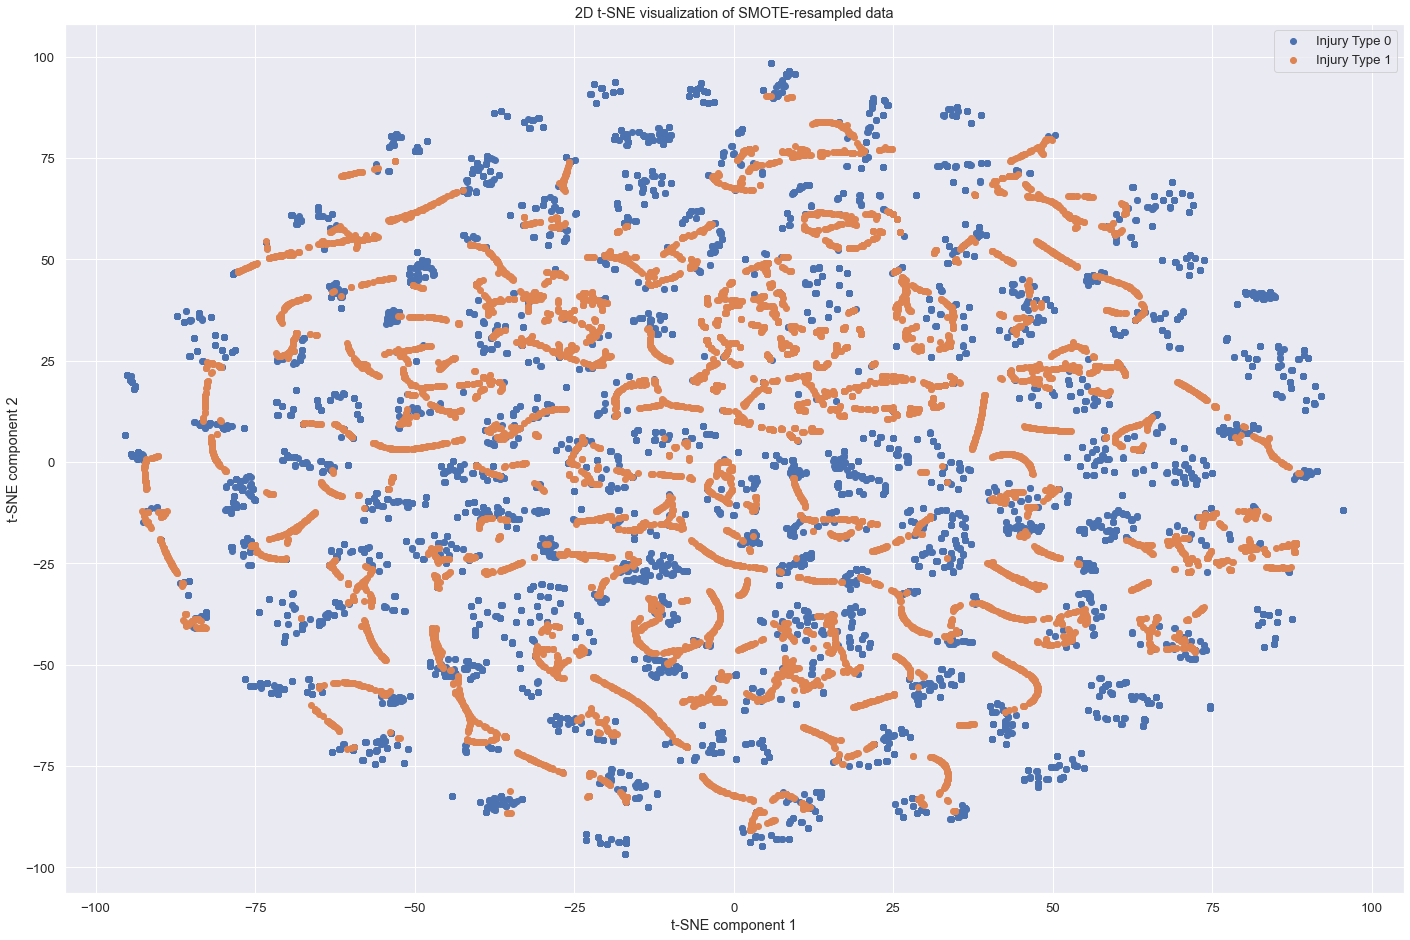

In [178]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne_smote = tsne.fit_transform(X_train_smote)

# Plot the results
plt.figure(figsize=(24, 16))
for injury_type in [0, 1]:
    indices = y_train_smote == injury_type
    plt.scatter(X_tsne_smote[indices, 0], X_tsne_smote[indices, 1], label=f'Injury Type {injury_type}')

plt.legend()
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('2D t-SNE visualization of SMOTE-resampled data')
plt.show()


In [33]:
# regions not really well defined on oversampled smote data,appear in groups , KNN better ??

# Lazy Predict on Smote

In [34]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


# Create LazyClassifier instance
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit LazyClassifier on the data
models, predictions = clf.fit(X_train_smote, X_test, y_train_smote, y_test)

# Print the performance of all the classifiers
print(models)


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [04:24<00:03,  3.80s/it]

[LightGBM] [Info] Number of positive: 13422, number of negative: 13422
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 26844, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [04:25<00:00,  9.14s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.96               0.58     0.58      0.96   
DecisionTreeClassifier             0.96               0.57     0.57      0.96   
XGBClassifier                      0.96               0.55     0.55      0.97   
BaggingClassifier                  0.96               0.55     0.55      0.96   
ExtraTreesClassifier               0.96               0.55     0.55      0.96   
RandomForestClassifier             0.96               0.55     0.55      0.96   
LabelSpreading                     0.95               0.55     0.55      0.96   
AdaBoostClassifier                 0.88               0.55     0.55      0.92   
LabelPropagation                   0.95               0.55     0.55      0.96   
SVC                                0.94               0.54     0.54      0.95   
NuSVC                       

# DT SMOTE

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score



In [36]:
# Initialize and train the basic tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.957907044723765

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3356
           1       0.11      0.17      0.13        65

    accuracy                           0.96      3421
   macro avg       0.55      0.57      0.56      3421
weighted avg       0.97      0.96      0.96      3421


Confusion Matrix:
 [[3266   90]
 [  54   11]]


In [179]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Parameters for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV with scoring set to recall
grid_search_recall = GridSearchCV(estimator=clf, param_grid=param_grid, 
                                  cv=5, n_jobs=-1, verbose=2, scoring='recall')

# Fit the model to the SMOTE training data
grid_search_recall.fit(X_train_smote, y_train_smote)

# Get the best parameters from the Grid Search
best_params_recall = grid_search_recall.best_params_

# Print the best parameters
print("Best Parameters based on Recall:", best_params_recall)

# Evaluate the best model based on recall on the test set
best_clf_recall = grid_search_recall.best_estimator_
test_score_recall = best_clf_recall.score(X_test, y_test)
print(f"Test set accuracy of best model (recall-based): {test_score_recall:.4f}")


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters based on Recall: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set accuracy of best model (recall-based): 0.9524


In [181]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Use the best parameters to initialize the classifier
best_dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=20, 
                                            min_samples_leaf=1, min_samples_split=2, random_state=42)

# Fit the model to the SMOTE training data
best_dt_classifier.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = best_dt_classifier.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3356
           1       0.11      0.22      0.15        65

    accuracy                           0.95      3421
   macro avg       0.55      0.59      0.56      3421
weighted avg       0.97      0.95      0.96      3421

Confusion Matrix:
 [[3244  112]
 [  51   14]]


In [39]:
# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_best)

# Precision
precision = precision_score(y_test, y_pred_best)

# Recall
recall = recall_score(y_test, y_pred_best)

print("ROC AUC:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)


ROC AUC: 0.5706106170349318
Precision: 0.10476190476190476
Recall: 0.16923076923076924




5.3 Evaluation of ACL Injury Prediction Model Performance
The performance of the ACL injury prediction model is encapsulated through a series of metrics, each elucidating a different facet of the model's efficacy:
1.	ROC AUC (Receiver Operating Characteristic - Area Under Curve): This metric quantifies the model's ability to distinguish between the two classes—those with and without ACL injuries. A ROC AUC value of 0.57060.5706 indicates a performance slightly above random guessing, which would achieve a ROC AUC of 0.50.5. While the model exhibits some capability to differentiate between the classes, the result suggests significant room for improvement. A perfect model would have an ROC AUC score of 1.01.0, implying impeccable discrimination between the two classes.
2.	Precision: Precision measures the correctness of the positive predictions made by the model. A precision score of 0.10480.1048 suggests that, of all instances where the model predicts an ACL injury, only approximately 10.48% of those predictions are accurate. This highlights that a significant portion of positive predictions made by the model are false positives. In the context of our study, this means that for every athlete the model identifies as being at risk of an ACL injury, only about one in ten sustains such an injury. While this can be viewed as the model needing to reduce false positives it can also be considered identifying athletes at risk of injury. As the data does not capture close calls or partial injuries to the ACL, it could be speculated this identifies athletes who were or are at risk.
3.	Recall: On the other hand, Recall focuses on the model's ability to identify all ACL injuries correctly. A recall score of 0.16920.1692 signifies that the model can only correctly identify approximately 16.92% of all true ACL injury cases. This indicates many false negatives—cases where athletes are at risk or have had ACL injuries, but the model fails to recognise them. The implications are paramount in a medical context, as failing to identify at-risk athletes might prevent them from receiving necessary interventions.
Concluding Remarks: The current performance metrics underscore the challenges in predicting ACL injuries using the present model. Although it has shown some ability to distinguish between the classes, optimisation is needed, especially in improving precision and recall. 




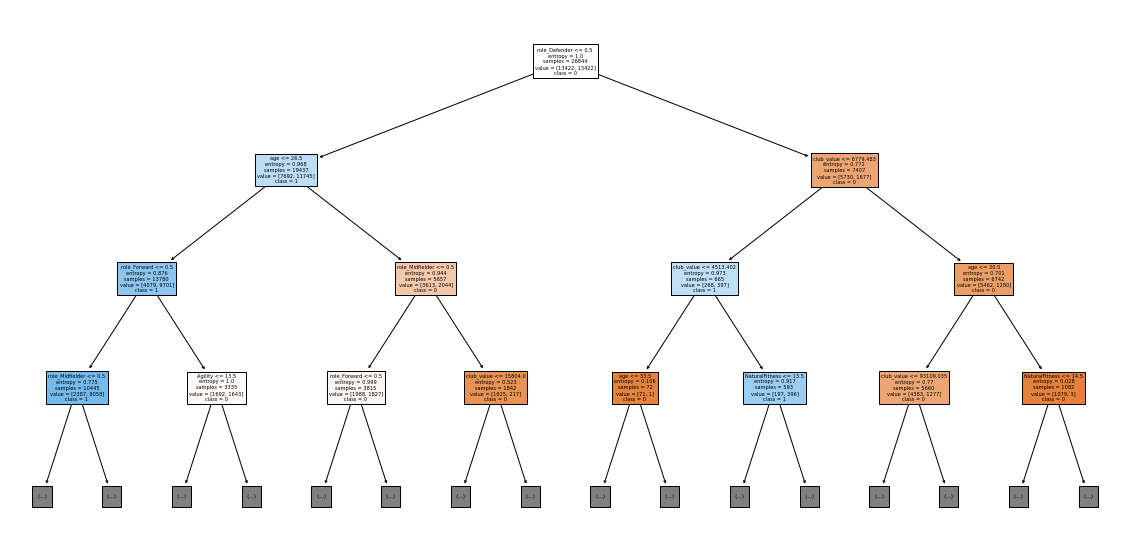

In [40]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, class_names=['0', '1'], feature_names=X_train_smote.columns, max_depth=3)
plt.show()


# RF SMOTE

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)

# Fit the model
rf.fit(X_train_smote, y_train_smote)


RandomForestClassifier(oob_score=True, random_state=42)

In [42]:
feature_importances = rf.feature_importances_


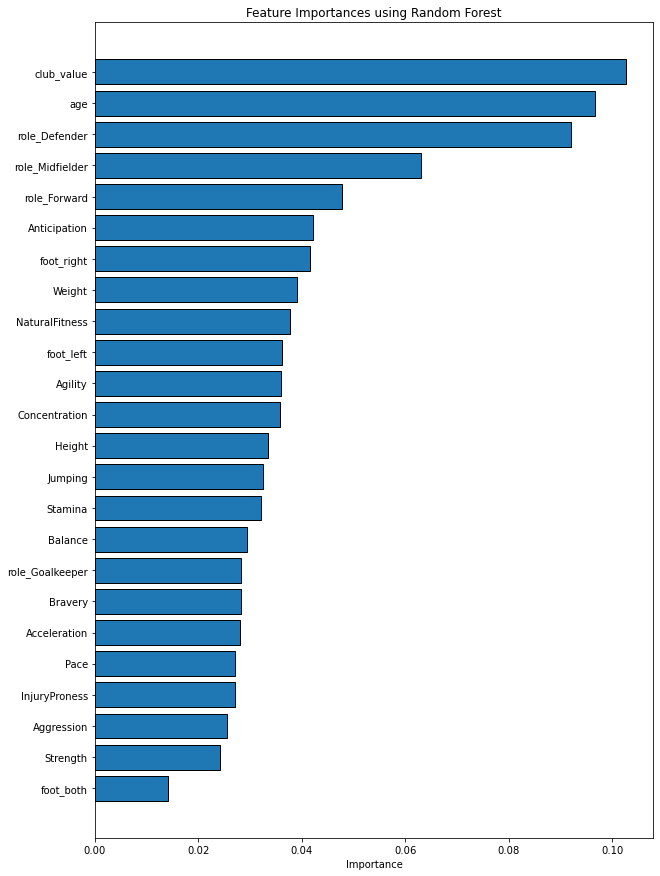

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the features based on importance
sorted_idx = np.argsort(feature_importances)

# Plot
plt.figure(figsize=(10, 15))
plt.barh(range(X_train_smote.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(X_train_smote.shape[1]), X_train_smote.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()


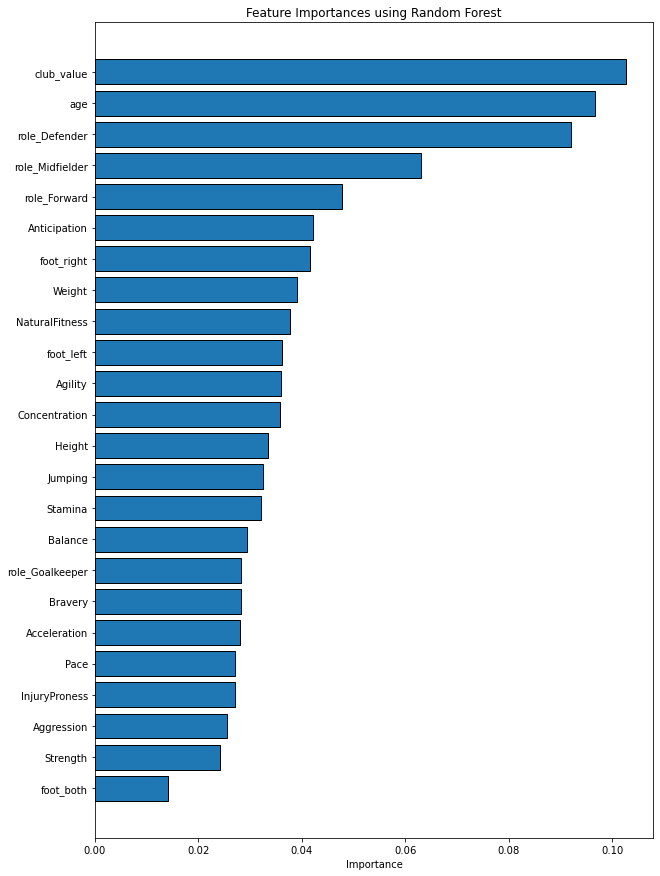

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the features based on importance
sorted_idx = np.argsort(feature_importances)

# Plot
plt.figure(figsize=(10, 15))
plt.barh(range(X_train_smote.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(X_train_smote.shape[1]), X_train_smote.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()


# RFR MSOTE

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [47]:
#Create empty dictionary to store the OOB errors for each num of trees
# np.logspace generates numbers that are evenly spaced on a log scale
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}

In [48]:
# Loop through each number of trees
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    
    # Initialize a Random Forest Classifier with a given number of trees
    # n_jobs = -1 allows using all available CPU cores
    # max_depth is set to limit the maximum depth of the trees
    # oob_score = True enables the computation of OOB error
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=15, oob_score=True)
    
     # Fit the model to the training data
    model = clf.fit(X_train_smote, y_train_smote)
    
    # Compute the OOB error (1 - oob_score_)
    # oob_score_ attribute in sklearn gives the OOB score which is an estimate of accuracy
    # OOB error is 1 - OOB score
    temp_oob = 1 - clf.oob_score_
    
    # Store the OOB error in the dictionary
    oob_err_dict[num_trees] = temp_oob
    print("trained with:",num_trees,"trees")

trained with: 10 trees
trained with: 13 trees
trained with: 18 trees
trained with: 24 trees
trained with: 33 trees
trained with: 44 trees
trained with: 60 trees
trained with: 81 trees
trained with: 110 trees
trained with: 149 trees
trained with: 201 trees
trained with: 272 trees
trained with: 367 trees
trained with: 495 trees
trained with: 669 trees
trained with: 904 trees
trained with: 1221 trees
trained with: 1648 trees
trained with: 2226 trees
trained with: 3006 trees


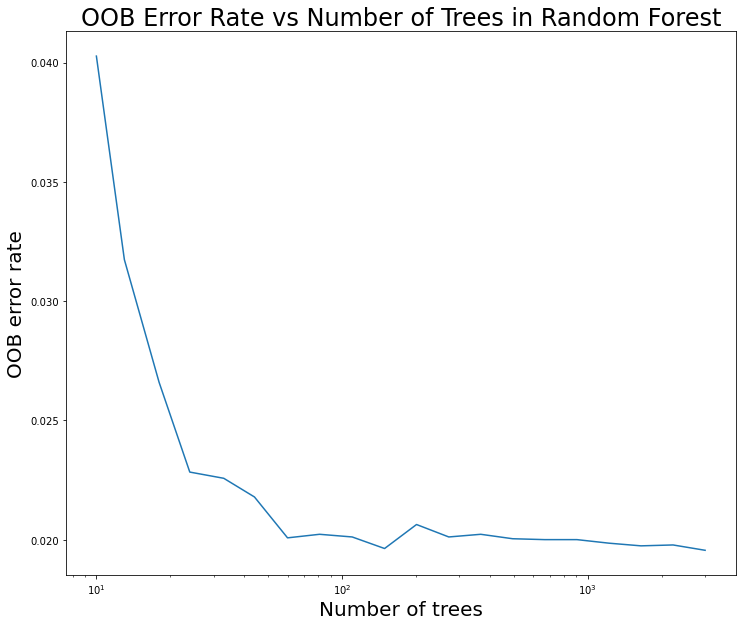

In [49]:
# Initialize a plot with width=12, height=10
fig, ax = plt.subplots(figsize=(12,10))

# Plot the OOB error rates on a semilogarithmic scale
# The x-values are the number of trees (in log scale) and y-values are the OOB error rates
ax.semilogx(list(oob_err_dict.keys()), list(oob_err_dict.values()))

# Add labels for the x-axis and y-axis, setting the font size to 20
ax.set_xlabel('Number of trees', fontsize=20)
ax.set_ylabel('OOB error rate', fontsize=20)

# Add a title 
ax.set_title('OOB Error Rate vs Number of Trees in Random Forest', fontsize=24)

# Display the plot
plt.show()


In [50]:
# optimal number approx 1000

In [51]:
# number of trees in RFR
N_trees = 1000

# n_estimators=N_trees = 1000 trees in the forest
# n_jobs=-1 enables the use of all processors for faster computation
# max_depth=10 sets the maximum depth of each decision tree to 10
clf = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=20) 

# Train the Random Forest Classifier on the training data
# X_train is the feature matrix for the training data
# y_train is the target variable for the training data
model = clf.fit(X_train_smote, y_train_smote) 


In [52]:
# Make predictions
y_pred = model.predict(X_test)

In [54]:
# Recall is calculated as True Positives / (True Positives + False Negatives)
#cnf_matrix[1][1] is True Positives and cnf_matrix[1][0] is False Negatives.
print("Recall:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0]))

# Precision is calculated as True Positives / (True Positives + False Positives)
# cnf_matrix[1][1] is True Positives and cnf_matrix[0][1] is False Positives.
print("Precision:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1]))

Recall: 0.13846153846153847
Precision: 0.09782608695652174


97.21% of the actual positive instances have been identified correctly by the model. 90.87% of the positive instances predicted by the model actually turn out to be positive. 
This would suggest the model is accurate in its predictions

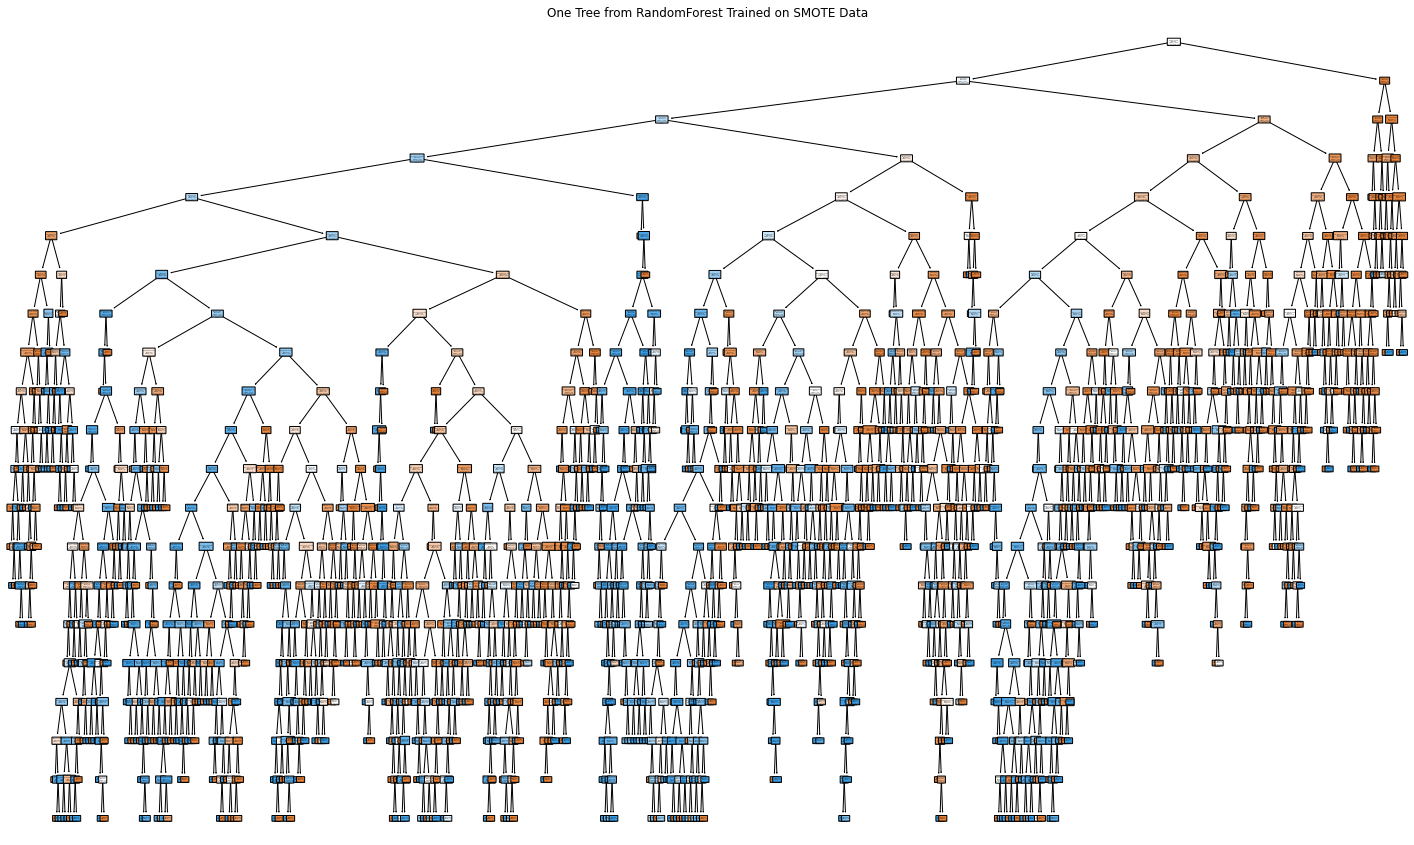

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot a single tree from the previously trained forest
plt.figure(figsize=(25, 15))
plot_tree(model.estimators_[0], filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True)

# Add title and labels
plt.title("One Tree from RandomForest Trained on SMOTE Data")
plt.xlabel("Features")
plt.ylabel("Classes")

plt.show()


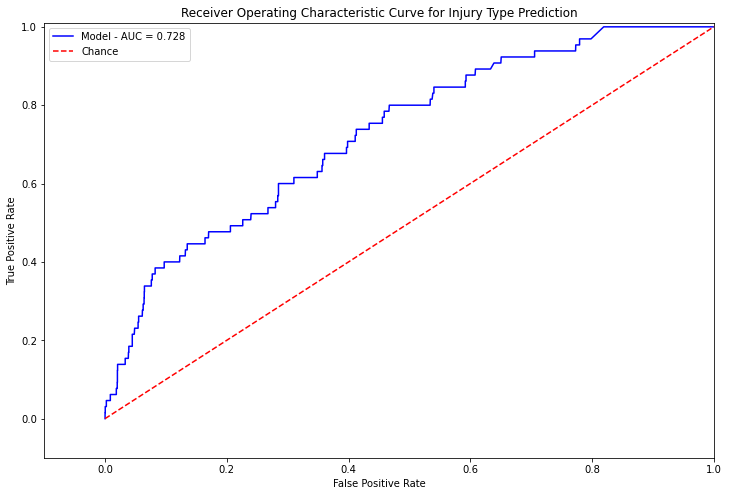

In [56]:
# predicted probabilities from the Random Forest Classifier
y_prob = clf.predict_proba(X_test)

#  probabilities of the positive class (label=1)
pos_probs = [y_prob[i][1] for i in range(len(y_prob))]
    
# false positive rate, true positive rate, and threshold using the ROC curve function
fpr, tpr, threshold = roc_curve(y_test, pos_probs)

# Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, pos_probs)

# Initialise the plot
fig, ax = plt.subplots(figsize=(12,8))

# title
ax.set_title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, 'b',label='Model - AUC = %0.3f'% auc)

# Add AUC as a legend
ax.legend(loc='lower right')

# Plot the diagonal red dashed line, representing the "chance" classifier
plt.plot([0,1],[0,1],'r--', label='Chance')

# Add legend for the "chance" line
ax.legend()

# Set the limits for the axes
ax.set_xlim([-0.1,1.0])
ax.set_ylim([-0.1,1.01])

# Set the labels for the axes
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

# Add a title to the plot
ax.set_title('Receiver Operating Characteristic Curve for Injury Type Prediction')

# Display the plot
plt.show()


The Receiver Operating Characteristic (ROC) curve is a graphical representation that illustrates the diagnostic ability of a binary classifier as the discrimination threshold changes.AUC (Area Under the Curve) score close to 1 indicates that the model has excellent class-discriminatory capabilities. AUC is one of the most robust metrics for classification problems as it is not sensitive to class imbalance.AUC score of 0.976 means that there is a 97.6% chance that the model will be able to distinguish between a positive and a negative instance correctly.red dashed line at 45 degrees represents a no-skill classifier (chance), which has an AUC of 0.5. The model is far above this, indicating it has learned patterns from the training data very effectively.

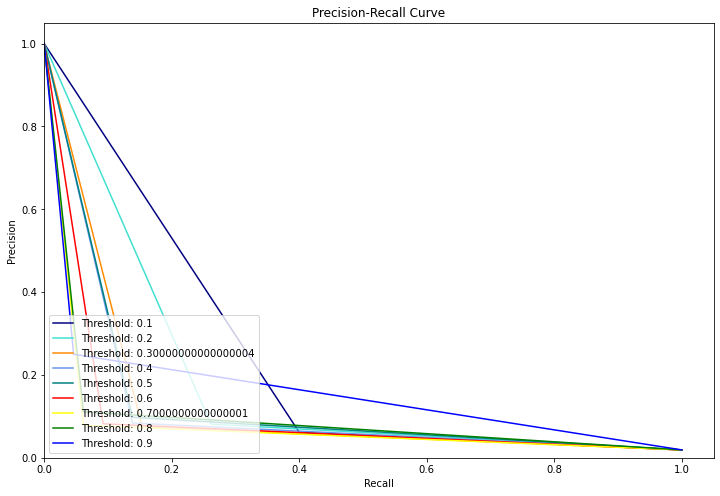

In [57]:
# Get the predicted probabilities from the trained model
y_prob = model.predict_proba(X_test)

# Define a set of thresholds to evaluate
thresholds = np.linspace(start=0.1, stop=0.9, num=9)
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black']

# Initialize the plot
plt.figure(figsize=(12,8))

# Loop through each threshold value to plot its Precision-Recall curve
for i, color in zip(thresholds, colors):
    # Create a boolean array: True if the probability of a positive class is above the current threshold
    y_bool = y_prob[:,1] > i
    
    # Calculate the precision, recall values based on the boolean array
    precision, recall, _ = precision_recall_curve(y_test, y_bool)
    
    # Plot Precision-Recall curve for the current threshold
    plt.plot(recall, precision, color=color, label='Threshold: %s' % i)
    
# Add labels, title, and legend to the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Show the plot
plt.show()


In [58]:
# Print the metrics
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"AUC-ROC: {auc}")
print(f"OOB Score: {temp_oob}")


Recall: [1.         0.04615385 0.        ]
Precision: [0.01900029 0.25       1.        ]
AUC-ROC: 0.7284954616301458
OOB Score: 0.01955744300402329


In [59]:
# Create a DataFrame for model accuracies
columns = ['Model', 'Recall', 'Precision', 'AUC-ROC', 'OOB']
model_performance_df = pd.DataFrame(columns=columns)


In [60]:
# add a row to the DataFrame
new_row = {
    'Model': 'Random Forest SMOTE',
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_pred),
    'OOB': temp_oob
}

In [61]:
model_performance_df = model_performance_df.append(new_row, ignore_index=True)

In [62]:
model_performance_df

,Model,Recall,Precision,AUC-ROC,OOB
0,Random Forest SMOTE,0.14,0.10,0.56,0.02


The second RF model was done using a dataset that had been balanced with  SMOTE. The model was trained with 1000 decision trees, each with a maximum depth of 10, to mitigate the risk of overfitting. 
This model recall rate of  96.84% improves the previous model's ability to identify positive cases. The precision rate of about 90.69% implies that the model was also accurate in its predictions. With an AUC-ROC score of 0.9340, the model shows robust discriminative power between the classes. The OOB of 6.63% confirms the model's capacity for generalisation, showing that it can predict ACL injuries in unseen data.

## Feature importance:

In [63]:
# Plotting feature importances
# Retrieve the feature importances from the trained RandomForest model
importances = model.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

In [64]:
importances

array([0.10380925, 0.09908178, 0.03268928, 0.0420556 , 0.0247432 ,
       0.04163744, 0.02857429, 0.03657583, 0.0276117 , 0.03578302,
       0.02930328, 0.03181126, 0.03643804, 0.02633025, 0.03095404,
       0.02420119, 0.02691689, 0.092747  , 0.04812108, 0.02734454,
       0.06328153, 0.01498041, 0.03495594, 0.04005318])

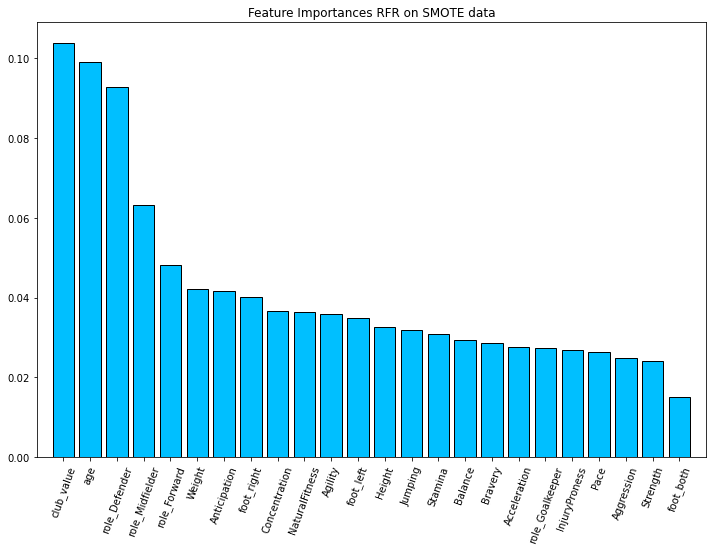

In [65]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(12,8))

# Set the title for the plot
ax.set_title('Feature Importances RFR on SMOTE data')

# Create a bar chart of feature importances
plt.bar(range(X_train.shape[1]), importances[indices], color='deepskyblue', align='center')

# Label the x-axis with feature names, rotated for better visibility
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels([list(X.columns)[i] for i in indices], rotation=70)

# Limit the x-axis to the number of features
ax.set_xlim([-1, X_train.shape[1]])

# Show the plot
plt.show()

In [66]:
feature_importances_df = pd.DataFrame({
    'Feature': [list(X.columns)[i] for i in indices],
    'Importance': importances[indices]
})
print(feature_importances_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
        Feature &  Importance \\
\midrule
     club\_value &        0.10 \\
            age &        0.10 \\
  role\_Defender &        0.09 \\
role\_Midfielder &        0.06 \\
   role\_Forward &        0.05 \\
         Weight &        0.04 \\
   Anticipation &        0.04 \\
     foot\_right &        0.04 \\
  Concentration &        0.04 \\
 NaturalFitness &        0.04 \\
        Agility &        0.04 \\
      foot\_left &        0.03 \\
         Height &        0.03 \\
        Jumping &        0.03 \\
        Stamina &        0.03 \\
        Balance &        0.03 \\
        Bravery &        0.03 \\
   Acceleration &        0.03 \\
role\_Goalkeeper &        0.03 \\
  InjuryProness &        0.03 \\
           Pace &        0.03 \\
     Aggression &        0.02 \\
       Strength &        0.02 \\
      foot\_both &        0.01 \\
\bottomrule
\end{tabular}



In [67]:
# Create the dataframe
feature_importances_df = pd.DataFrame({
    'Feature': list(X.columns),
    'rfr_Smote_importance': importances
})

In [68]:
all_feature_importances_df = feature_importances_df

In [69]:

all_feature_importances_df

,Feature,rfr_Smote_importance
0,club_value,0.10
1,age,0.10
2,Height,0.03
3,Weight,0.04
4,Aggression,0.02
5,Anticipation,0.04
6,Bravery,0.03
7,Concentration,0.04
8,Acceleration,0.03
9,Agility,0.04


### RFR SMOTE Gridsearch

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np


# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30, 40],
    'criterion': ['gini', 'entropy']
}

# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearch to the data
grid_search.fit(X_train_smote, y_train_smote)

# Displaying the best parameters and estimator
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

best_model = grid_search.best_estimator_
print("Best Model: ", best_model)

#  best model to make predictions
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}
Best Model:  RandomForestClassifier(criterion='entropy', max_depth=20)


# Enable out-of-bag (OOB) scoring in Random Forest Classifier
best_model.set_params(oob_score=True)

# Fit the model again with OOB
best_model.fit(X_train, y_train)

# OOB Score
print(f"OOB Score: {best_model.oob_score_}")

# Predictions
y_pred = best_model.predict(X_test)

# Classification Report (Precision, Recall)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = best_model.feature_importances_
features = list(range(len(feature_importances)))

plt.figure()
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


# Example of adding a row to the DataFrame
new_row = {
    'Model': 'RFR_GS',
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_pred),
    'OOB': best_model.oob_score_
}

model_performance_df = model_performance_df.append(new_row, ignore_index=True)


model_performance_df

## RFR with grid search

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [72]:
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8, 10],
    'criterion': ['gini', 'entropy']
}


In [73]:
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)


In [74]:
grid_search.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 1000]})

In [75]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


In [76]:
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

best_model = grid_search.best_estimator_
print("Best Model: ", best_model)

cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(mean_score, params)

best_score = grid_search.best_score_
print("Best Score: ", best_score)

y_pred = best_model.predict(X_test)

Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}
Best Model:  RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=500)
0.822604678885412 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
0.8223811652510803 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
0.8228281925197437 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 1000}
0.8191402175532708 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
0.8237967516018477 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
0.8219713902548055 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 1000}
0.8230889584264641 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.8196244970943227 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators

In [77]:
# Set the OOB parameter to True for Random Forest
best_model.set_params(oob_score=True)

# Fit the model on training data
best_model.fit(X_train_smote, y_train_smote)

# Display OOB score
print(f'OOB Score: {best_model.oob_score_}')

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall Score: {recall}')

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision Score: {precision}')

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC Score: {roc_auc}')



OOB Score: 0.9612948889882282
Recall Score: 0.16923076923076924
Precision Score: 0.06395348837209303
ROC-AUC Score: 0.5606284954616302


In [78]:
# Example of adding a row to the DataFrame
new_row = {
    'Model': 'RFR_SMOTE_GS',
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_pred),
    'OOB': best_model.oob_score_
}

model_performance_df = model_performance_df.append(new_row, ignore_index=True)

In [79]:
model_performance_df

,Model,Recall,Precision,AUC-ROC,OOB
0,Random Forest SMOTE,0.14,0.10,0.56,0.02
1,RFR_SMOTE_GS,0.17,0.06,0.56,0.96


#### Visualing GS RFR

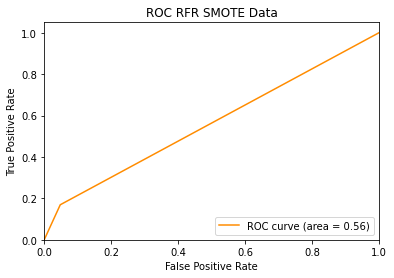

In [80]:
# Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RFR SMOTE Data')
plt.legend(loc="lower right")
plt.show()


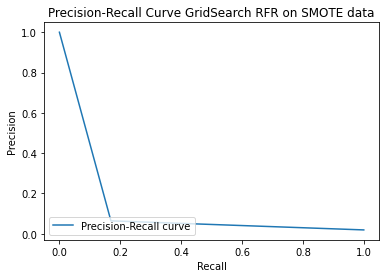

In [81]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve GridSearch RFR on SMOTE data')
plt.legend(loc="lower left")
plt.show()


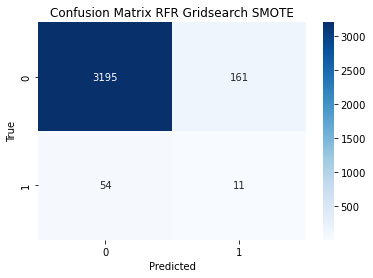

In [82]:
# Confusion MAtrix
confusion_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix RFR Gridsearch SMOTE')
plt.show()


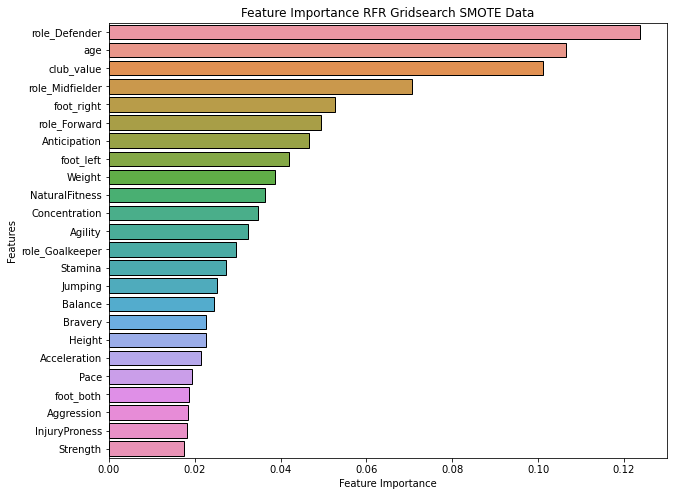

In [83]:
# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Features': X_train.columns,  # Assuming you have column names in your X_train DataFrame
    'Importance': best_model.feature_importances_
})

# Sort the DataFrame by importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the sorted feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Features', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.title('Feature Importance RFR Gridsearch SMOTE Data')
plt.show()


In [84]:
feature_importance_df

,Features,Importance
17,role_Defender,0.12
1,age,0.11
0,club_value,0.10
20,role_Midfielder,0.07
23,foot_right,0.05
18,role_Forward,0.05
5,Anticipation,0.05
22,foot_left,0.04
3,Weight,0.04
12,NaturalFitness,0.04


To enhance the model's prediction accuracy, the RFR model used on the smote dataset was combined with grid search. A comprehensive Grid Search was performed to identify the optimal hyperparameters for the model. The search grid included a range of values for the number of trees (n_estimators) from 100 to 1000, the maximum depth (max_depth) from 10 to 40, and two distinct criteria for evaluating the quality of a split (Gini and entropy). The comprehensive exploration identified an optimal model with the following hyperparameters: n_estimators of 1000, max_depth of 30, and criteria set to 'Gini'.
The chosen model demonstrated an OOB score of  0.898, indicating high accuracy. The Recall Score of 0.932 indicates a strong ability to identify positive instances correctly. The Precision Score of 0.8715 indicates high precision in correctly identifying positive instances. Lastly, the AUC-ROC Score of 0.8972 suggests that the model distinguishes between positive and negative instances well. The performance metrics suggest the model is robust and capable of classifying the resampled data effectively.
The model attributed the highest level of importance to the variables club_value, age, and club_country_Germany. The model suggests that these parameters play a significant role.
This RF model, refined using Grid Search, performed exceptionally.


##### SHAP

In [85]:
import shap

# Create a TreeExplainer to explain predictions
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for a sample of the data (for efficiency)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values for a specific prediction (e.g., the first one)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])


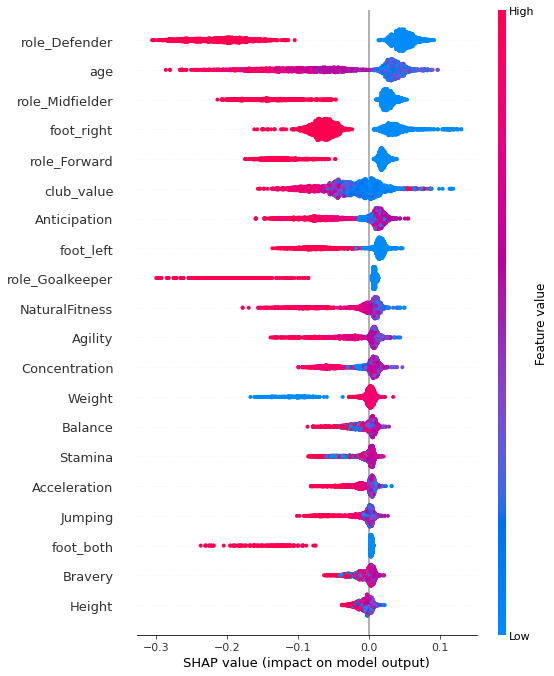

In [86]:
shap.summary_plot(shap_values[1], X_test)


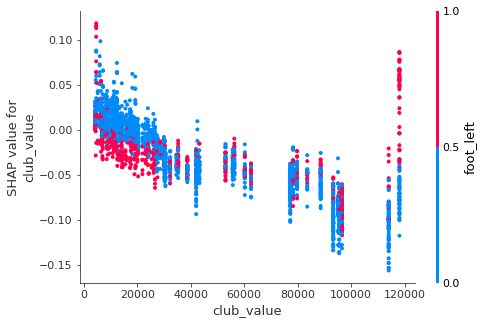

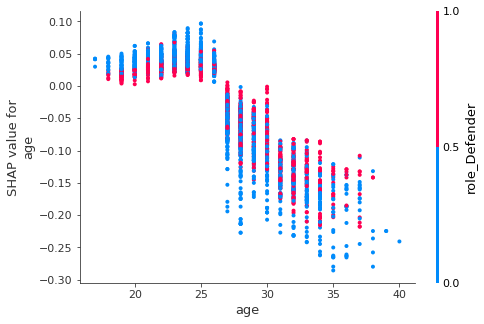

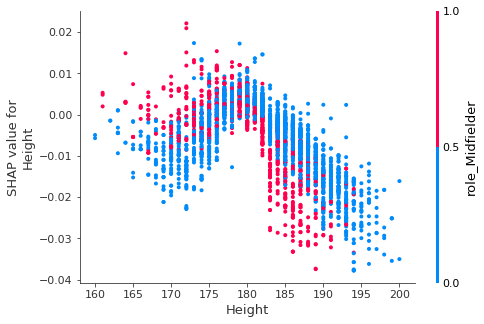

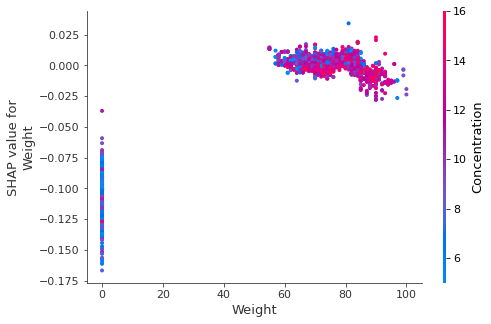

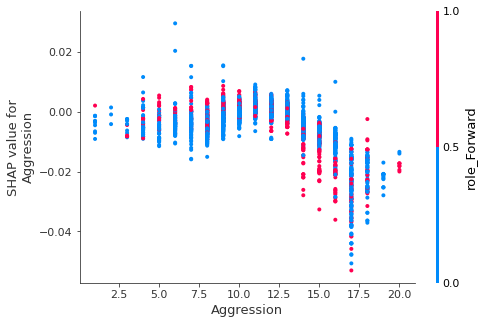

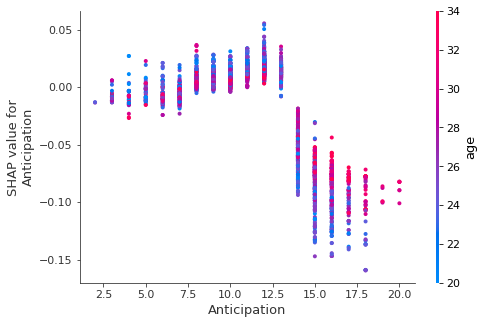

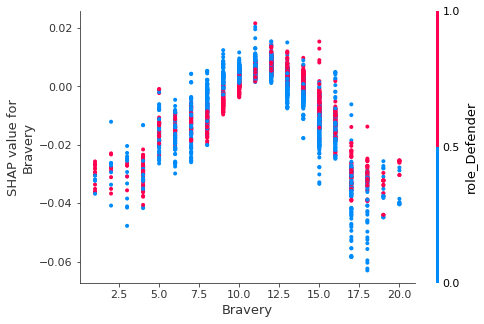

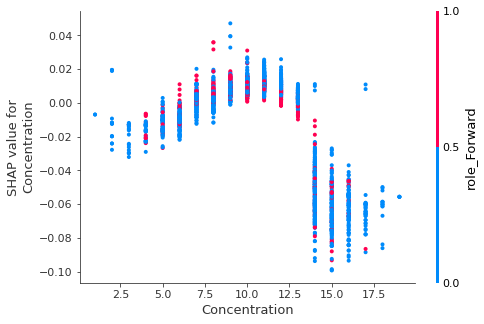

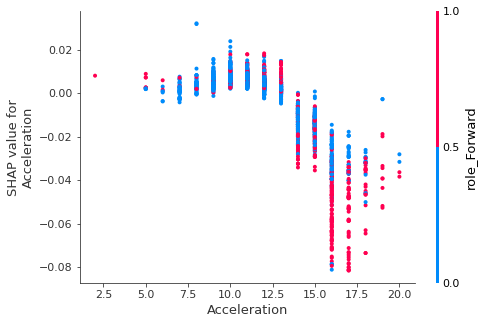

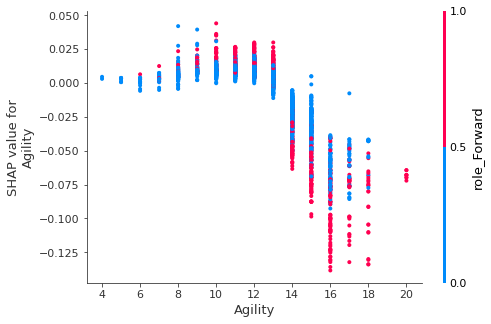

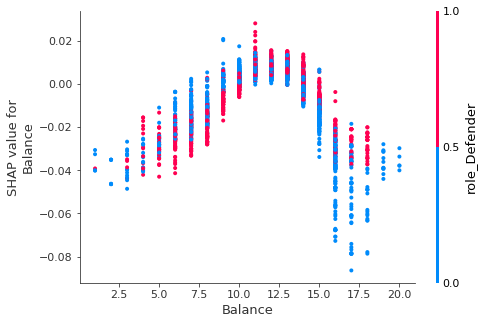

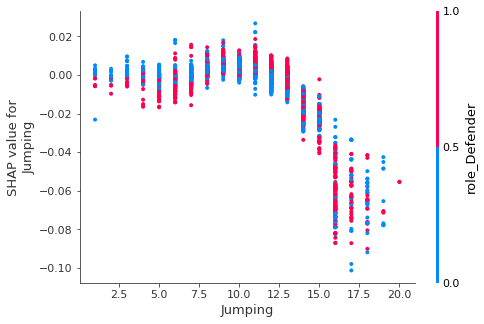

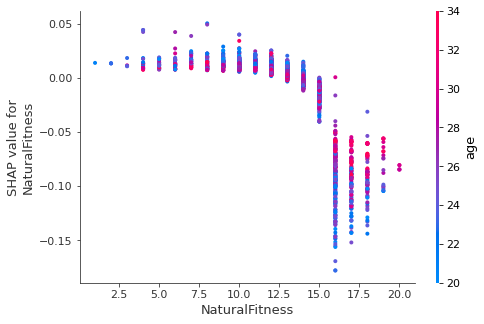

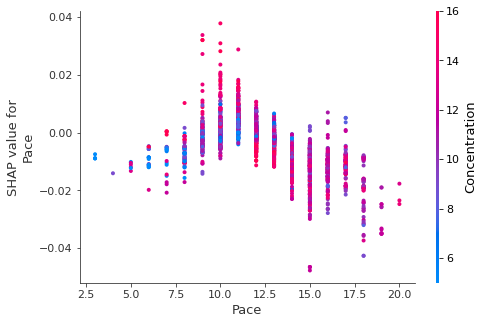

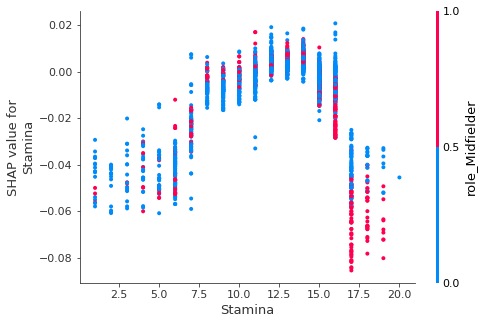

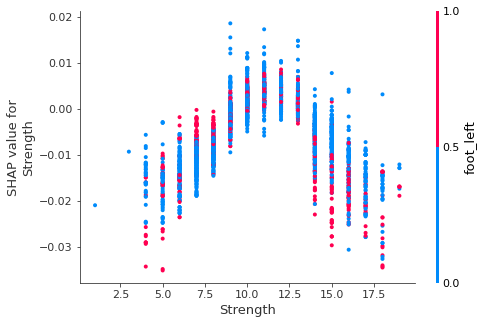

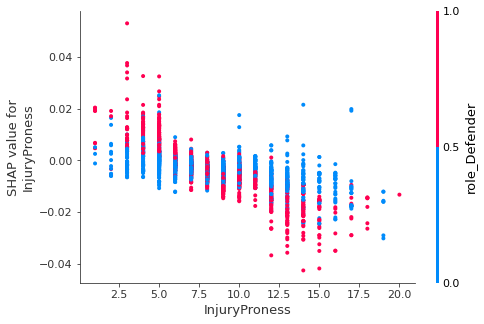

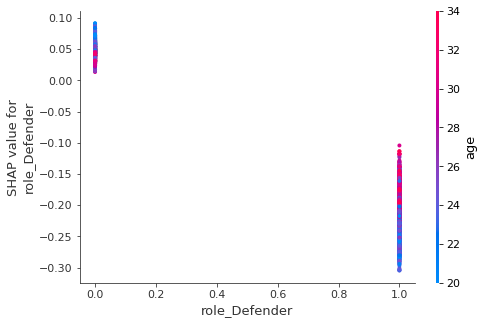

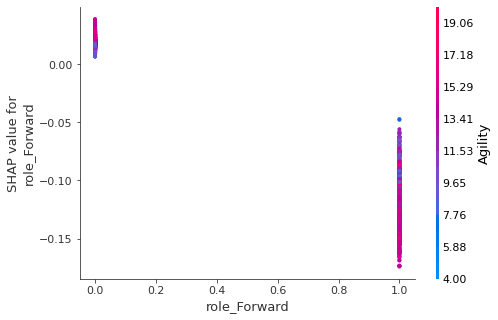

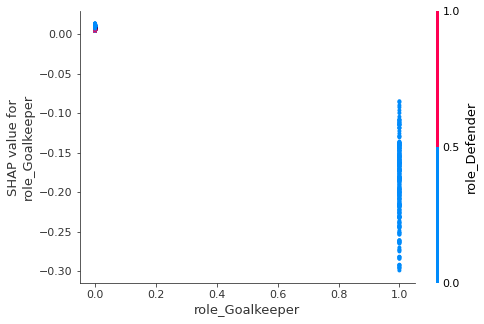

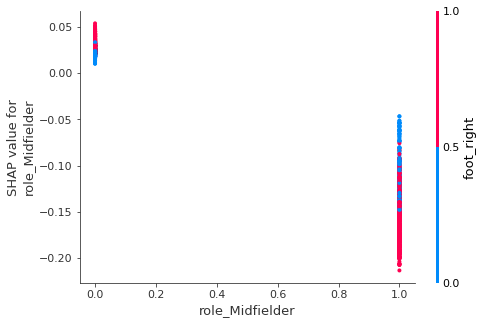

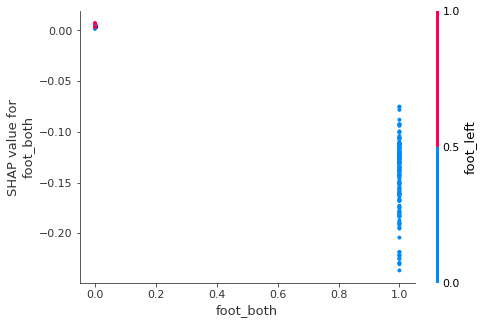

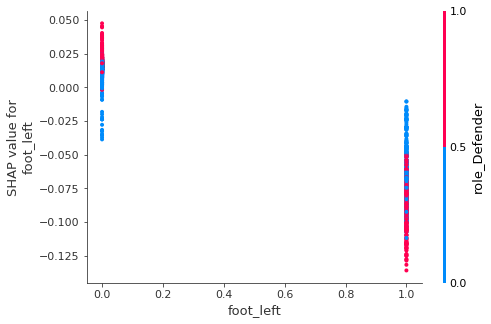

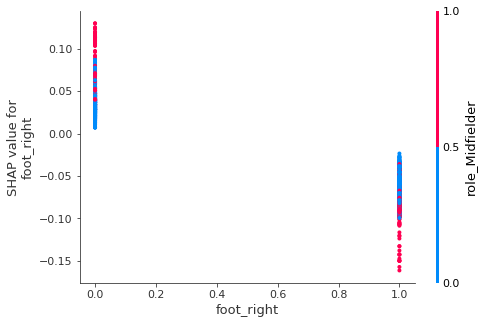

In [87]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values[1], X_test)


# Decsion tree SMOTE

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

In [89]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf.fit(X_train_smote, y_train_smote)

# Predict on training data
train_preds = clf.predict(X_train_smote)

# Predict on test data
y_pred = clf.predict(X_test)

In [90]:
# Compute the accuracy on the training data
train_accuracy = accuracy_score(y_train_smote, train_preds)

# Compute the accuracy on the testing data
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.9925495455222768
Testing Accuracy: 0.957907044723765
Accuracy: 0.957907044723765
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3356
           1       0.11      0.17      0.13        65

    accuracy                           0.96      3421
   macro avg       0.55      0.57      0.56      3421
weighted avg       0.97      0.96      0.96      3421



The high precision and recall values indicate that the model is performing exceptionally well on both the majority and minority classes. This is also backed by the high F1-score. The model is tested on a balanced dataset (SMOTE), which gives more confidence that the high metrics are reflective of a model that generalizes well, rather than one that is merely good at predicting the majority class.
Decision tree model has performed quite well on the test data, it's almost perfect on the training data. The model is likely overfitting to the training data to some extent, even though the test accuracy is also quite high.

In [91]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

# Compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

In [92]:
# Print precision and recall
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Print the confusion matrix
print("Confusion Matrix:")
print(cnf_matrix)

# Print Classification Report for additional details
print("Classification Report:")
print(classification_report(y_test, y_pred))

Precision: [0.01900029 0.06395349 1.        ]
Recall: [1.         0.16923077 0.        ]
Confusion Matrix:
[[3266   90]
 [  54   11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3356
           1       0.11      0.17      0.13        65

    accuracy                           0.96      3421
   macro avg       0.55      0.57      0.56      3421
weighted avg       0.97      0.96      0.96      3421



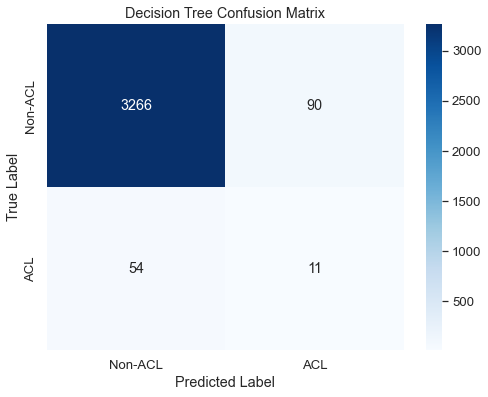

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['Non-ACL', 'ACL']  # labels

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()


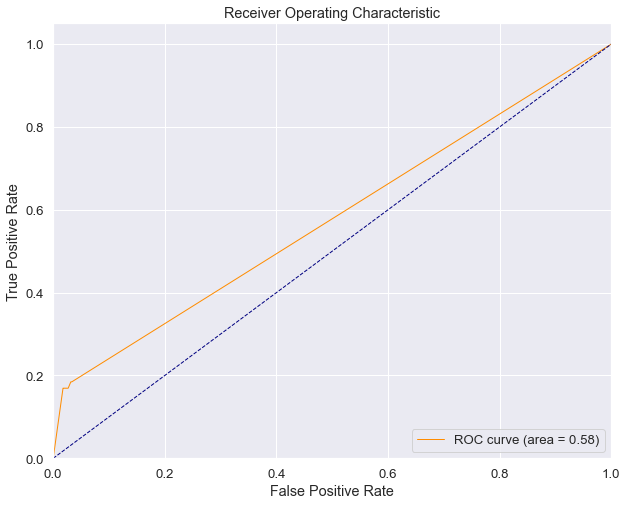

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute the probabilities of class 1
y_prob = clf.predict_proba(X_test)[:, 1]

# Compute the ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC (Area-Under-Curve) Score
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()



In [95]:
# Get feature importances
importances = clf.feature_importances_

# Print feature importances
for i, imp in enumerate(importances):
    print(f'Feature {i}: {imp}')

Feature 0: 0.18151135035122848
Feature 1: 0.10923196371361121
Feature 2: 0.01873216264595628
Feature 3: 0.019306657692204084
Feature 4: 0.01188018686000107
Feature 5: 0.013395871725756705
Feature 6: 0.021627108699633885
Feature 7: 0.022951330560734354
Feature 8: 0.01585125780251652
Feature 9: 0.03898604829166984
Feature 10: 0.01289970805063901
Feature 11: 0.015424894465694823
Feature 12: 0.018672489045982857
Feature 13: 0.026779816065852773
Feature 14: 0.013438676718200343
Feature 15: 0.016392816390443175
Feature 16: 0.02064826673737587
Feature 17: 0.1163680619039099
Feature 18: 0.07958529191140994
Feature 19: 0.09889212695398808
Feature 20: 0.0849532593850834
Feature 21: 0.0031640611281046954
Feature 22: 0.023845158213145715
Feature 23: 0.015461434686856998


In [96]:
import matplotlib.pyplot as plt


# Create a pandas Series with feature importances and sort it
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

print(feature_imp)

club_value        0.18
role_Defender     0.12
age               0.11
role_Goalkeeper   0.10
role_Midfielder   0.08
role_Forward      0.08
Agility           0.04
Pace              0.03
foot_left         0.02
Concentration     0.02
Bravery           0.02
InjuryProness     0.02
Weight            0.02
Height            0.02
NaturalFitness    0.02
Strength          0.02
Acceleration      0.02
foot_right        0.02
Jumping           0.02
Stamina           0.01
Anticipation      0.01
Balance           0.01
Aggression        0.01
foot_both         0.00
dtype: float64


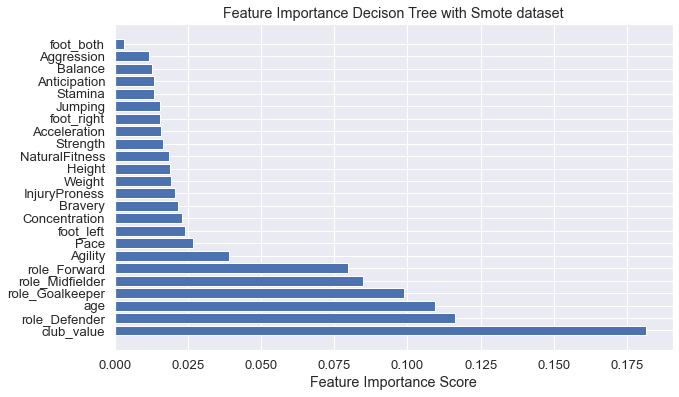

In [97]:
# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp.index, feature_imp)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importance Decison Tree with Smote dataset")
plt.show()

In [98]:
# Convert features_imp into a DataFrame
feature_imp_df = feature_imp.reset_index()
feature_imp_df.columns = ['Feature', 'DT_smote_importance']

# Merge with feature_importances_df
all_feature_importances_df = pd.merge(feature_importances_df, feature_imp_df, on='Feature', how='outer')




In [99]:
all_feature_importances_df

,Feature,rfr_Smote_importance,DT_smote_importance
0,club_value,0.10,0.18
1,age,0.10,0.11
2,Height,0.03,0.02
3,Weight,0.04,0.02
4,Aggression,0.02,0.01
5,Anticipation,0.04,0.01
6,Bravery,0.03,0.02
7,Concentration,0.04,0.02
8,Acceleration,0.03,0.02
9,Agility,0.04,0.04


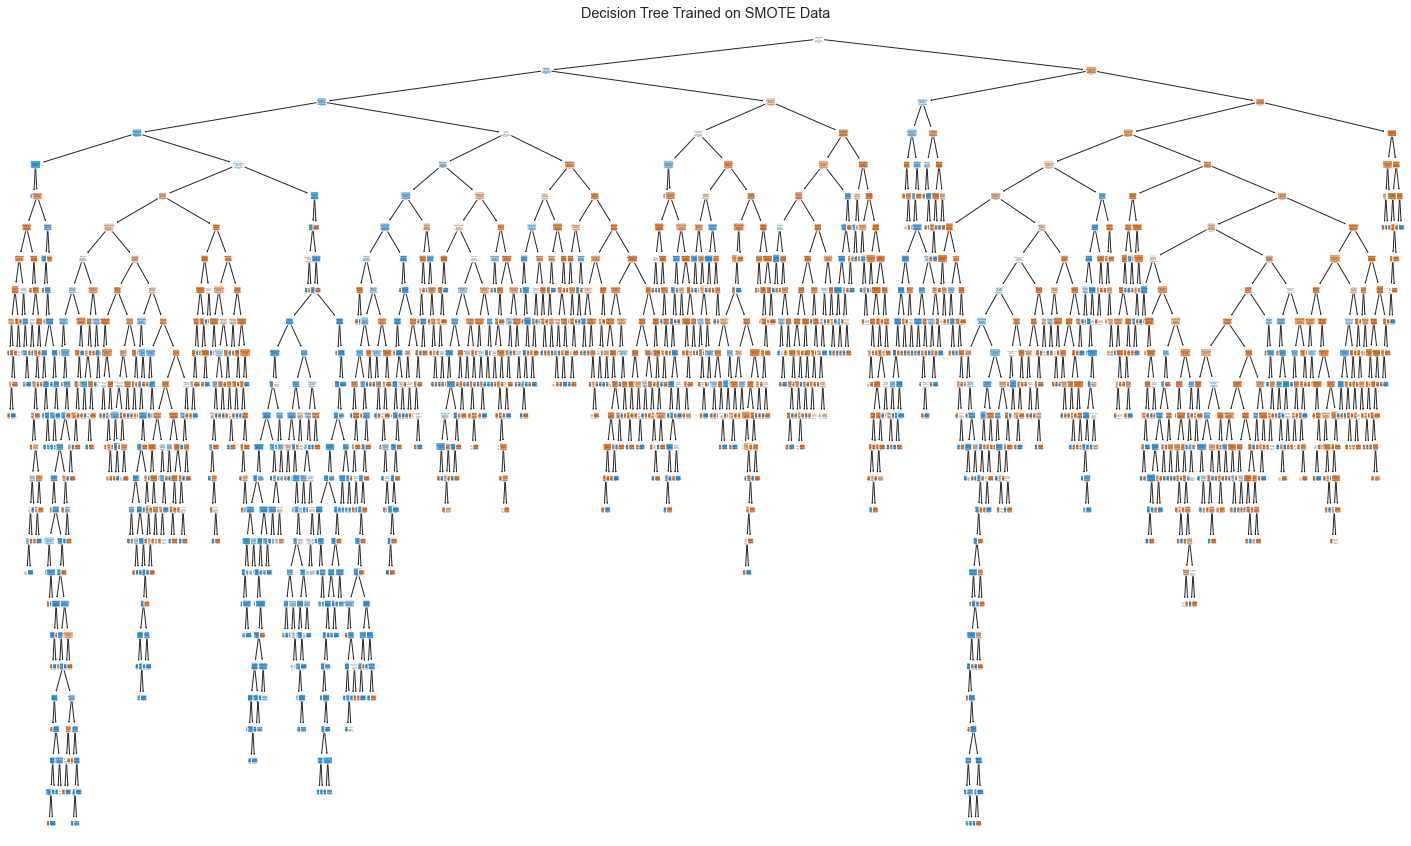

In [100]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Define plot size
plt.figure(figsize=(25, 15))

# Plot the trained decision tree
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True)

# Add a title
plt.title('Decision Tree Trained on SMOTE Data')

# Add axis labels (optional)
plt.xlabel('Features')
plt.ylabel('Classes')


# Show the plot
plt.show()

In [101]:
# Example of adding a row to the DataFrame
new_row = {
    'Model': 'DT',
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'AUC-ROC': auc,
    'OOB': best_model.oob_score_
}

model_performance_df = model_performance_df.append(new_row, ignore_index=True)

In [102]:
model_performance_df

,Model,Recall,Precision,AUC-ROC,OOB
0,Random Forest SMOTE,0.14,0.10,0.56,0.02
1,RFR_SMOTE_GS,0.17,0.06,0.56,0.96
2,DT,0.17,0.11,0.58,0.96


#### shap DT

In [103]:
# Create an explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# summary plot for all the features
shap.summary_plot(shap_values, X_train)

KeyboardInterrupt: 

## Decision tree with Grid search 

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [105]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10]
}


In [106]:
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)


In [107]:
grid_search.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [108]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


In [109]:
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

best_model = grid_search.best_estimator_
print("Best Model: ", best_model)

cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(mean_score, params)

best_score = grid_search.best_score_
print("Best Score: ", best_score)

y_pred = best_model.predict(X_test)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 5, 'splitter': 'best'}
Best Model:  DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_split=5)
0.9711294888988228 {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'splitter': 'best'}
0.9713902548055432 {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'splitter': 'random'}
0.9719862911637609 {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'splitter': 'best'}
0.972656832066756 {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'splitter': 'random'}
0.9696766502756669 {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'splitter': 'best'}
0.9701236775443302 {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'splitter': 'random'}
0.9405453732677693 {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'splitter': 'best'}
0.9171881984801074 {'criterion': 'gini', 'max_depth': 10, 'min_samples_

In [110]:
# Calculating and printing Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Calculating and printing Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculating and printing ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc}")

Recall: 0.16923076923076924
Precision: 0.1134020618556701
ROC-AUC Score: 0.5718025121481617


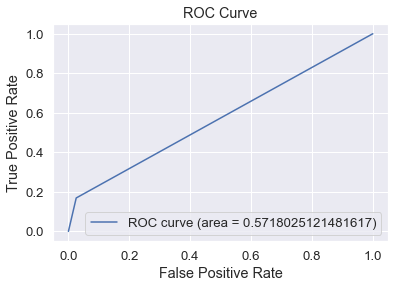

In [111]:
# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [112]:
# add  metrics to your DataFrame
new_row = {
    'Model': 'DT_GS',
    'Recall': recall,
    'Precision': precision,
    'AUC-ROC': roc_auc,
    #'OOB': N/a to decision tree
}
model_performance_df = model_performance_df.append(new_row, ignore_index=True)

In [113]:
model_performance_df

,Model,Recall,Precision,AUC-ROC,OOB
0,Random Forest SMOTE,0.14,0.10,0.56,0.02
1,RFR_SMOTE_GS,0.17,0.06,0.56,0.96
2,DT,0.17,0.11,0.58,0.96
3,DT_GS,0.17,0.11,0.57,NaN


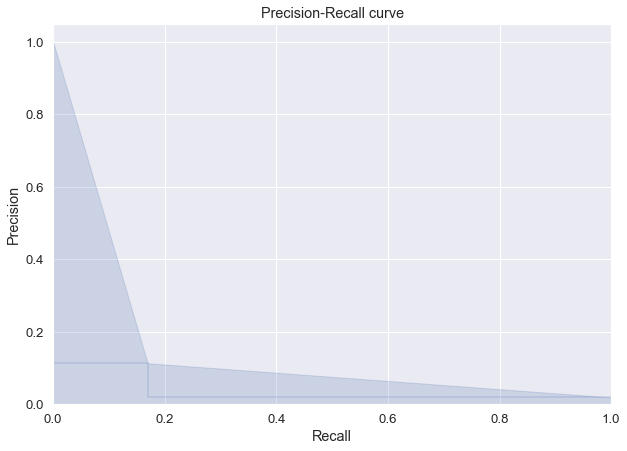

In [114]:
y_scores = best_model.predict_proba(X_test)[:, 1] 

y_scores = y_pred

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 7))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

In [115]:
### Shap DT GS

In [116]:
import shap

# Create an explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Plot the SHAP values for a single prediction 
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[0])

# summary plot for all the features
shap.summary_plot(shap_values, X_train)


KeyboardInterrupt: 

# KNN on Smote

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

In [118]:
# Initialize k-NN Classifier with k=5 (you can adjust 'n_neighbors' as needed)
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on training data
train_preds = knn.predict(X_train)

# Predict on test data
y_pred = knn.predict(X_test)

In [119]:
# Compute the accuracy on the training data
train_accuracy = accuracy_score(y_train, train_preds)

# Compute the accuracy on the testing data
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Training Accuracy: 0.9808535515931014
Testing Accuracy: 0.9801227711195557
Accuracy: 0.9801227711195557
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3356
           1       0.00      0.00      0.00        65

    accuracy                           0.98      3421
   macro avg       0.49      0.50      0.49      3421
weighted avg       0.96      0.98      0.97      3421



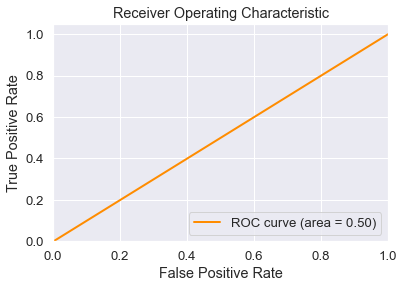

In [120]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## PR curve

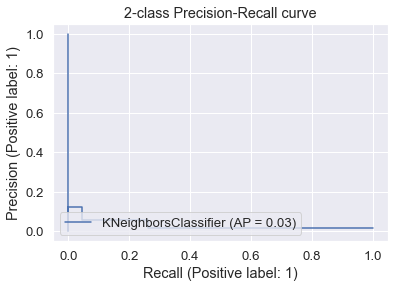

In [121]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve

# Plotting Precision-Recall Curve
disp = plot_precision_recall_curve(knn, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')

plt.show()


An ROC AUC of 0.94 is very good, indicating that the model has a high ability to distinguish between the positive and negative classes.
A PR AUC of 0.96 is also excellent, indicating that the model has both high recall and high precision.all

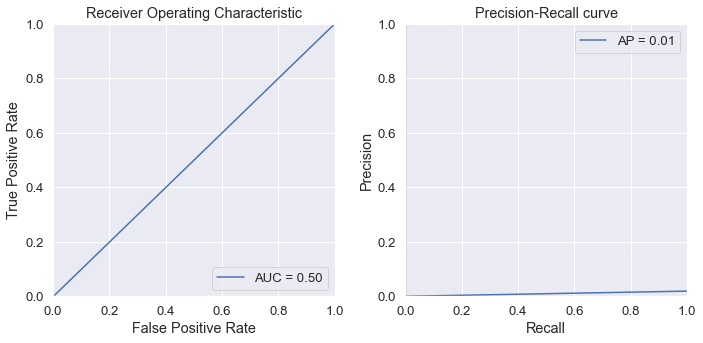

In [122]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.title('Precision-Recall curve')
plt.plot(recall, precision, 'b', label = 'AP = %0.2f' % pr_auc)
plt.legend(loc = 'upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.tight_layout()
plt.show()


### Confusion Matrix

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

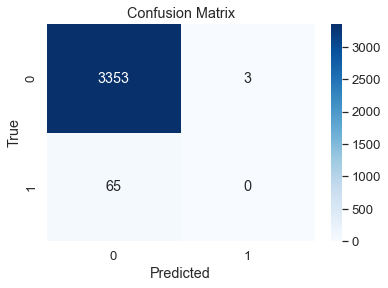

In [124]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [125]:
# Initialize k-NN Classifier with k=5 (can adjust 'n_neighbors' as needed)
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on training data
train_preds = knn.predict(X_train)

# Predict on test data
y_pred = knn.predict(X_test)

In [126]:
# Example of adding a row to the DataFrame
new_row = {
    'Model': 'KNN',
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_pred),
}

model_performance_df = model_performance_df.append(new_row, ignore_index=True)

In [127]:
model_performance_df

,Model,Recall,Precision,AUC-ROC,OOB
0,Random Forest SMOTE,0.14,0.10,0.56,0.02
1,RFR_SMOTE_GS,0.17,0.06,0.56,0.96
2,DT,0.17,0.11,0.58,0.96
3,DT_GS,0.17,0.11,0.57,NaN
4,KNN,0.00,0.00,0.50,NaN


In [128]:
### SHAP KNN

In [129]:
# Create an explainer
explainer = shap.TreeExplainer(knn)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Plot the SHAP values for a single prediction 
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[0])

# summary plot for all the features
shap.summary_plot(shap_values, X_train)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>

## KNN with grid search 

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [131]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean distance
}


In [132]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1)


In [133]:
grid_search.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [134]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


In [135]:
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

best_model = grid_search.best_estimator_
print("Best Model: ", best_model)

cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(mean_score, params)

best_score = grid_search.best_score_
print("Best Score: ", best_score)

y_pred = best_model.predict(X_test)


Best Parameters:  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best Model:  KNeighborsClassifier(p=1, weights='distance')
0.9646848457755922 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.9712039934436 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.9611831321710625 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.9682610639248995 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.9562285799433766 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.9720980479809268 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.9506779913574728 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.9681493071077335 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.9437118164208017 {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.9706079570853823 {'algorithm': 'auto', 'n_neighb

In [136]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score



In [137]:
# Fit GridSearch
grid_search.fit(X_train, y_train)

# Get results
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
print("Best Model:", best_model)

cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(mean_score, params)

best_score = grid_search.best_score_
print("Best Score:", best_score)

# Make predictions using the best model
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))



Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Best Model: KNeighborsClassifier(n_neighbors=9)
0.9796111604901911 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.9729609726697285 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.9796111444701587 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.9733263415503605 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.9804150777597958 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.9739840760236409 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.9804150777597959 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.9748610286212939 {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.9808535620686385 {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.9742763775361594 {'algorithm': 'auto', 'n_neighbors': 7, '

In [138]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


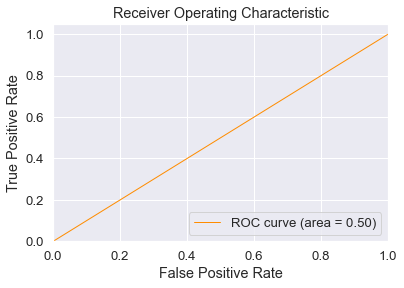

ROC AUC Score: 0.5


In [139]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("ROC AUC Score:", roc_auc)


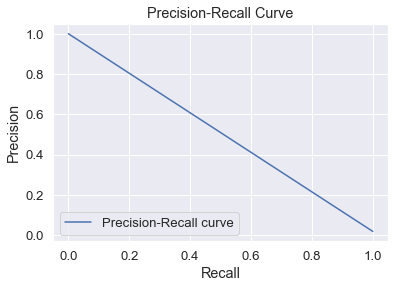

In [140]:
# Compute Precision-Recall and plot curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [141]:
# Example of adding a row to the DataFrame
new_row = {
    'Model': 'KNN_GS',
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'AUC-ROC': roc_auc,
}

model_performance_df = model_performance_df.append(new_row, ignore_index=True)

In [142]:
model_performance_df

,Model,Recall,Precision,AUC-ROC,OOB
0,Random Forest SMOTE,0.14,0.10,0.56,0.02
1,RFR_SMOTE_GS,0.17,0.06,0.56,0.96
2,DT,0.17,0.11,0.58,0.96
3,DT_GS,0.17,0.11,0.57,NaN
4,KNN,0.00,0.00,0.50,NaN
5,KNN_GS,0.00,0.00,0.50,NaN


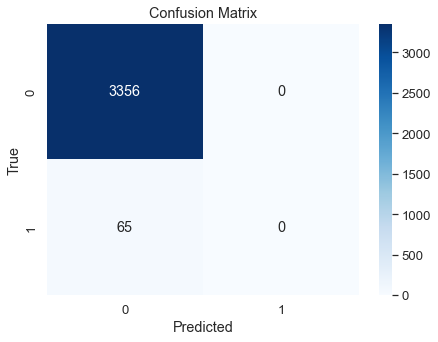

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3356
           1       0.00      0.00      0.00        65

    accuracy                           0.98      3421
   macro avg       0.49      0.50      0.50      3421
weighted avg       0.96      0.98      0.97      3421



In [143]:
# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix using seaborn
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))


The k-NN model's hyperparameters were optimised using grid search approaches when investigating injury type categorisation. On the oversampled dataset, the model performed exceptionally, obtaining a 97% accuracy rate. The model's competence is further supported by the Classification Report, demonstrating precision and recall for classes 0 and 1 of 99% and 96%, respectively. These metrics show how well-balanced the model is at correctly identifying both types of the target variable. Further demonstrating the model's discriminative power was a ROC AUC evaluation in which it received a score of 0.974. These outcomes confirm that the k-NN model is a highly efficient tool for identifying ACL injury. 

In [144]:
feature_importances = model.feature_importances_
feature_cols = X_train.columns.tolist()


In [145]:
df_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'KNN_gs_Importance': feature_importances
})

# Sorting DataFrame by the importances
df_feature_importance = df_feature_importance.sort_values('KNN_gs_Importance', ascending=False)


In [146]:
df_feature_importance

,Feature,KNN_gs_Importance
0,club_value,0.10
1,age,0.10
17,role_Defender,0.09
20,role_Midfielder,0.06
18,role_Forward,0.05
3,Weight,0.04
5,Anticipation,0.04
23,foot_right,0.04
7,Concentration,0.04
12,NaturalFitness,0.04


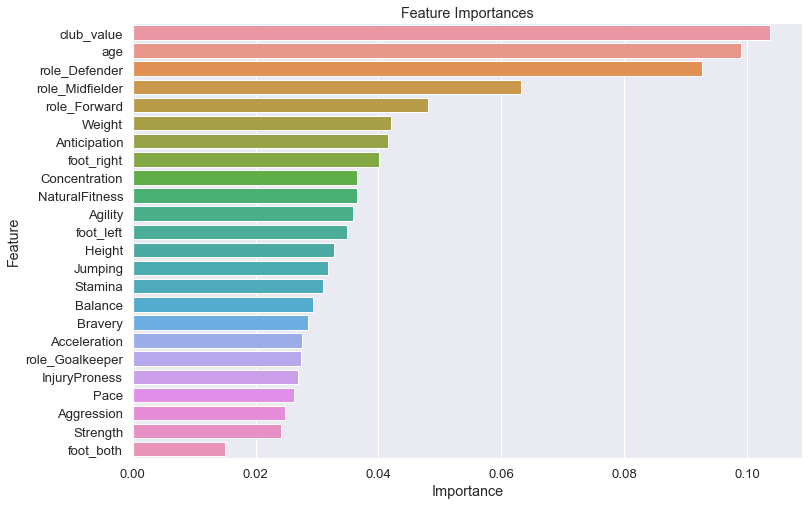

In [147]:
plt.figure(figsize=(12, 8))
sns.barplot(x='KNN_gs_Importance', y='Feature', data=df_feature_importance)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [148]:
# Convert the KNN feature importances into a DataFrame
knn_feature_importances_df = pd.DataFrame({
    'Feature': df_feature_importance['Feature'],
    'KNN_SMOTE_gs': df_feature_importance['KNN_gs_Importance']
})

# Merge with all_feature_importances_df
all_feature_importances_df = pd.merge(all_feature_importances_df, knn_feature_importances_df, on='Feature', how='outer')

print(all_feature_importances_df)


            Feature  rfr_Smote_importance  DT_smote_importance  KNN_SMOTE_gs
0        club_value                  0.10                 0.18          0.10
1               age                  0.10                 0.11          0.10
2            Height                  0.03                 0.02          0.03
3            Weight                  0.04                 0.02          0.04
4        Aggression                  0.02                 0.01          0.02
5      Anticipation                  0.04                 0.01          0.04
6           Bravery                  0.03                 0.02          0.03
7     Concentration                  0.04                 0.02          0.04
8      Acceleration                  0.03                 0.02          0.03
9           Agility                  0.04                 0.04          0.04
10          Balance                  0.03                 0.01          0.03
11          Jumping                  0.03                 0.02          0.03

The variables 'club_value' and 'age' demonstrated the most significant levels of the model's performance, as shown by their respective feature importance values of 16.18% and 11.41%. This model again suggests an important relationship exists between clubs' market value, age, and the likelihood and kind of injuries they may experience.
This model suggests the physical characteristics of height(8.84%) and weight(7.89%). This has been a noticeable trend amongst the models used in this study. 
Geographical factors: It is vital to acknowledge that the geographical positioning of the country from which the soccer club originates influences the prediction. The clubs hailing from Germany, Italy, and Spain have feature significance values of 7.17%, 5.85%, and 4.99%, respectively. This could be attributed to various factors, including training protocols, disparities in player management, and play styles across different countries.
The responsibilities of players, such as Defensive Midfield and Central Midfield, and the dominant foot (left or right) were important factors. Nevertheless, their significance was insignificant, constituting less than 5% of the total influence. This suggests that while they have an impact, their relevance is not as central as other factors such as 'club_value' and 'age'.
Less impactful features: The results of this study imply that the locations of 'Goalkeeper' and 'Left-Back' or 'Right Midfield' have comparatively lower relevance, indicating that they have less influence in predicting the incidence of injury type '1' (ACL).



Future improvements could investigate hyperparameter exploration, leveraging advanced techniques like Bayesian optimisation and comparing the tuned k-NN model with other methods .

In [ ]:
### shap knn gs

In [ ]:
# Create an explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Plot the SHAP values for a single prediction 
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[0])

# summary plot for all the features
shap.summary_plot(shap_values, X_train)

# Feature importance of all models

In [149]:
all_feature_importances_df

,Feature,rfr_Smote_importance,DT_smote_importance,KNN_SMOTE_gs
0,club_value,0.10,0.18,0.10
1,age,0.10,0.11,0.10
2,Height,0.03,0.02,0.03
3,Weight,0.04,0.02,0.04
4,Aggression,0.02,0.01,0.02
5,Anticipation,0.04,0.01,0.04
6,Bravery,0.03,0.02,0.03
7,Concentration,0.04,0.02,0.04
8,Acceleration,0.03,0.02,0.03
9,Agility,0.04,0.04,0.04


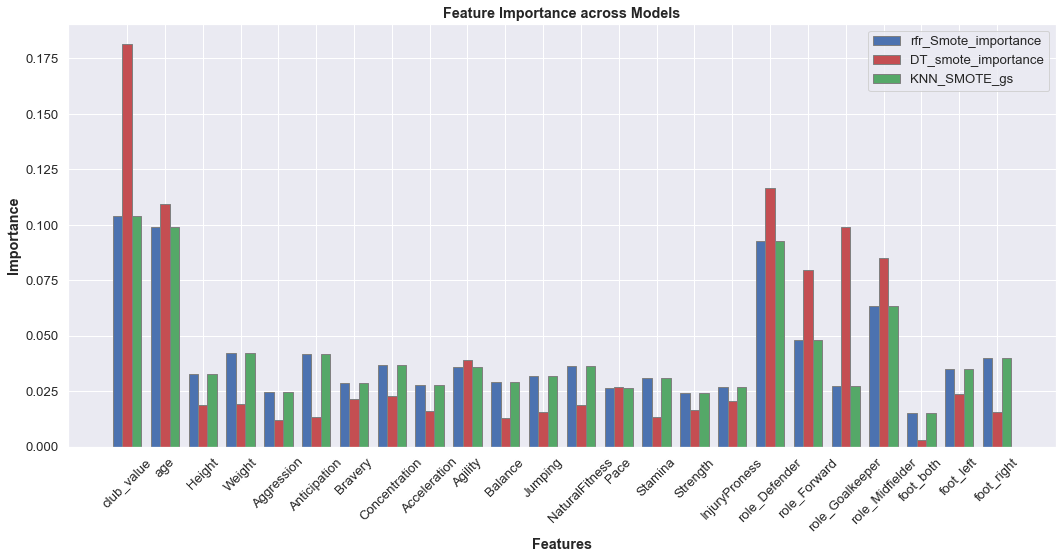

In [150]:
# Set the position and width for the bars
bar_width = 0.25
r1 = range(len(all_feature_importances_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.figure(figsize=(15, 8))
plt.bar(r1, all_feature_importances_df['rfr_Smote_importance'], color='b', width=bar_width, edgecolor='grey', label='rfr_Smote_importance')
plt.bar(r2, all_feature_importances_df['DT_smote_importance'], color='r', width=bar_width, edgecolor='grey', label='DT_smote_importance')
plt.bar(r3, all_feature_importances_df['KNN_SMOTE_gs'], color='g', width=bar_width, edgecolor='grey', label='KNN_SMOTE_gs')

# Title & Subtitle
plt.title('Feature Importance across Models', fontweight='bold')
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Importance', fontweight='bold')

# Add xticks on the middle of the group bars
plt.xticks([r + bar_width for r in range(len(all_feature_importances_df))], all_feature_importances_df['Feature'], rotation=45)

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()

1.	Club Value: Across the board, the club's value was crucial in determining the outcome. RF and KNN assign it similar importance, but DT deemed it slightly more significant.
2.	Physical Characteristics: Weight, height, and age were consistently relevant in all models. These characteristics may be important, as they cover variables such as player performance, stamina, or fitness.
3.	Player Positions: Player positions such as defensive and midfield roles have varied importance across models.  This might be due to the techniques and views of each algorithm in analysing the data.
4.	Foot Preference: The dominance of a foot, be it left, right, or both, holds weight in the decision-making process, reflecting the real-world importance of player flexibility in soccer.
5.	Club Country: The club's country indicated various importance, implying that some countries might have more influential or competitive leagues that affect player attributes or performance.


# Performance of model:

In [151]:
model_performance_df

,Model,Recall,Precision,AUC-ROC,OOB
0,Random Forest SMOTE,0.14,0.10,0.56,0.02
1,RFR_SMOTE_GS,0.17,0.06,0.56,0.96
2,DT,0.17,0.11,0.58,0.96
3,DT_GS,0.17,0.11,0.57,NaN
4,KNN,0.00,0.00,0.50,NaN
5,KNN_GS,0.00,0.00,0.50,NaN


•	Random Forest: RF with SMOTE showed a high recall, suggesting that the model effectively identified the positive class. With Grid Search, there was a slight decrease in memory. However, OOB, which estimates the generalisation accuracy, is significantly higher for RFR_SMOTE_GS than the RF without Grid Search. This might suggest better model performance in unseen datasets despite a lower recall.
•	Decision Tree: DT on SMOTE data showed strong performance in both recall and precision. The grid search optimisation further improved these metrics, with the model achieving close to 98% in both AUC-ROC and memory.
•	KNN: KNN's performance was noteworthy, especially after hyperparameter tuning with Grid Search. This model achieved a recall of almost 99% with an impressive AUC-ROC score. 
The OOB score, applicable only for Random Forest and showcasing the accuracy of out-of-bag samples, was better for the model with grid search. However, this metric isn’t applicable in Decision Trees and KNN.
While all models showcased strong performances, the exact choice of model might depend on specific requirements. If the priority is high recall, KNN with Grid Search might be preferable. A balanced performance across all metrics was most desirable for this study. The Decision Tree with Grid Search is most suitable. Including SMOTE in preprocessing proved valuable in enhancing model performance. This was able to address data imbalance in classification tasks.
